<!DOCTYPE html>
<html>
<head>
<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

tr:nth-child(even) {
  background-color: #dddddd;
}
</style>
</head>
<body>

<h2>The Team:</h2>

<table>
  <tr>
    <th>Group Member</th>
    <th>EID</th>
  </tr>

  <tr>
    <td>Simran Kaur</td>
    <td>sk57859</td>
  </tr>

  <tr>
    <td>Dinesh Bandaru</td>
    <td>db46729</td>
  </tr>

  <tr>
    <td>Ali Khan</td>
    <td>ask3467</td>
  </tr>

  <tr>
    <td>Biyun Yuan</td>
    <td>by3764</td>
  </tr>
  
</table>

</body>
</html>

Our team’s aim here is to transform the way companies allocate their marketing resources to make smarter, data-driven choices instead of relying on guesswork and personal opinions. To accomplish this, we have used Linear Programming modeling to come up with an optimal marketing budget strategy.

# Imports

In [ ]:
!pip install gurobipy

In [ ]:
import pandas as pd
import numpy as np
import gurobipy as gp
from google.colab import drive
import warnings
# Ignore warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Python Notebook csv/"

# Question 1,2,3
1) Assume that your company is deciding how to spend a marketing budget of $10M. You work in the marketing department as a data scientist and the chief marketing officer has asked you write a report recommending how to spread this budget among several marketing mediums. Your department has employed an outside consulting firm to estimate the return on investment (ROI) of each marketing medium under consideration. The results are in the table below, and also in a CSV attached to this assignment:

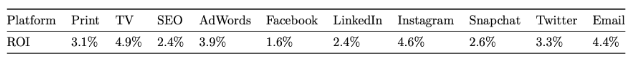

2) On top of these ROIs, your boss has decided to constrain your budget as follows:

a. The amount invested in print and TV should be no more than the amount spent on Facebook and Email. Surprisingly, email seems to be a great channel for reaching real people.

b. The total amount used in social media (Facebook, LinkedIn, Instagram, Snapchat, and Twitter) should be at least twice of SEO and AdWords.

c. For each platform, the amount invested should be no more than $3M.

3) Formulate the marketing budget allocation problem as a linear program. Use gurobi to find the optimal budget allocation.

## Reading Files

In [ ]:
# Defining the marketing budget
marketing_budget  = 10000000
currency_round = 1000000

In [ ]:
# Reading the CSV with the ROI data for both the consulting firms
roi_data = pd.read_csv(file_path + 'ROI_data.csv')
roi_data = roi_data.set_index('Platform')
roi_data

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
Platform,,,,,,,,,,
ROI,0.031,0.049,0.024,0.039,0.016,0.024,0.046,0.026,0.033,0.044
Second Firms ROI Estimate,0.049,0.023,0.024,0.039,0.044,0.046,0.026,0.019,0.037,0.026


In [ ]:
# Reading the monthly ROI for the whole year
roi_mat = pd.read_csv(file_path + 'roi_mat.csv').rename(columns= {"Unnamed: 0": "Period"})
roi_mat

,Period,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,January,4.0,3.6,2.4,3.9,3.0,3.5,3.6,2.25,3.5,3.5
1,February,4.0,3.9,2.7,3.8,4.3,3.2,2.7,1.80,3.7,3.5
2,March,3.5,2.9,3.1,3.8,2.4,4.1,3.7,2.60,4.2,2.5
3,April,3.8,3.1,2.4,4.4,2.4,3.8,3.7,2.50,3.6,2.9
4,May,3.5,3.2,1.9,3.4,2.7,2.7,3.9,2.20,4.5,3.9
5,June,4.0,3.2,2.7,3.4,3.4,3.0,4.5,2.10,3.8,4.1
6,July,3.9,3.6,2.0,4.4,3.9,3.7,4.3,1.80,4.0,3.8
7,August,4.2,3.3,2.8,4.2,2.0,3.7,3.6,1.50,4.4,4.3
8,September,4.1,2.8,2.5,4.2,2.9,3.7,2.8,2.50,4.0,3.4
9,October,3.0,3.0,3.1,4.6,3.1,3.3,3.2,2.30,2.5,3.2


In [ ]:
# Storing the just the ROI of 1st consulting firm in a list
medium_list = roi_data.columns.to_list()

medium_list_len = len(medium_list)

## Gurobi Optimizing Function

Creating a function to optimize the Gurobi model, which has the fixed constraints, and we will pass the variable constraints as parameters

Adding the constraints for the models below:
- Main Constraint: The maximum marketing budget including all the mediums is $10M

- Constraint 1 : The amount invested in print and TV should be no more than the amount spent on Facebook and Email

- Constraint 2 : The total amount used in social media (Facebook, LinkedIn, Instagram, Snapchat, and Twitter) should be at least twice of SEO and AdWords.

- Constraint 3 : For each platform, the amount invested should be no more than $3M.

In [ ]:
def gurobi_optimize(medium_budget_dict,marketing_budget =  10000000, n_constrs =3):
  #We have added the marketing budget and n_constrs as optional parameters, this will be particularly helpful for when our marketing budget
  #is changing for Question 7 and when we are removing 3rd constraint in a part of Question 5
    model = gp.Model()

    #Adding the variables for Model 1, the variables being the dollars to be invested in each medium
    ojModX = model.addMVar(medium_list_len,lb = 0)

    #Setting the objective for Model 1, which is maximising the ROI, this is is the sum of Returns from all the mediums
    model.setObjective(gp.quicksum(medium_budget_dict[medium_list[i]]*ojModX[i] for i in range(medium_list_len)),sense=gp.GRB.MAXIMIZE)


    conlist=[0]*3
    # then come back and change the list entries one by one to represent each constraint
    conlist[0] = model.addConstr(gp.quicksum(ojModX[i] for i in range(medium_list_len)) <= marketing_budget)

    conlist[1] = model.addConstr(ojModX[medium_list.index('Print')] + ojModX[medium_list.index('TV')]
                                 <= ojModX[medium_list.index('Facebook')] + ojModX[medium_list.index('Email')] )

    conlist[2] = model.addConstr(ojModX[medium_list.index('Facebook')] + ojModX[medium_list.index('LinkedIn')] +
                                 ojModX[medium_list.index('Instagram')] + ojModX[medium_list.index('Snapchat')] +
                                 ojModX[medium_list.index('Twitter')] >= 2 *(ojModX[medium_list.index('SEO')] +
                                                                             ojModX[medium_list.index('AdWords')]))
    # Setting the upperbound
    if n_constrs == 3: #utilizing the n_constr value here
      amountlessthan3m = model.addConstrs(ojModX[i] <= 3000000 for i in range(medium_list_len))


    model.Params.OutputFlag = 0 # tell gurobi to shut up!!

    model.optimize()

    return model,ojModX

## Question 3

In [ ]:
#Running the Gurobi Function created for the First recommended model
medium1 = roi_data.columns.tolist()
budget1 = list(roi_data.loc['ROI'].values)

medium_budget1_dict = dict(zip(medium1,budget1))

model1,ojModX1 = gurobi_optimize(medium_budget1_dict)

Restricted license - for non-production use only - expires 2024-10-28


In [ ]:
# Returns based on 1st consulting firms ROI data
model1.objVal

456000.0

In [ ]:
# The allocation of $10M amongst various Ad-Platforms
ojModX1.x

array([      0., 3000000.,       0., 1000000.,       0.,       0.,
       3000000.,       0.,       0., 3000000.])

* The optimal solution (maximum return) from the recommendations from Model 1 is \$ 456k

In [ ]:
# <!-- The Model gives out the following recommendations
output1 = list(ojModX1.x)
recommender_df = pd.DataFrame({'Medium': medium_list, 'Allocation 1':budget1,'Model 1': output1})
print('The Model 1 gives out the following recommendations, the values are in $')
recommender_df

The Model 1 gives out the following recommendations, the values are in $


,Medium,Allocation 1,Model 1
0,Print,0.031,0.0
1,TV,0.049,3000000.0
2,SEO,0.024,0.0
3,AdWords,0.039,1000000.0
4,Facebook,0.016,0.0
5,LinkedIn,0.024,0.0
6,Instagram,0.046,3000000.0
7,Snapchat,0.026,0.0
8,Twitter,0.033,0.0
9,Email,0.044,3000000.0


Now, the Manager has asked to cross-verify with the 2nd Recommendation from a different company, let's see their analysis as well.

# Question 4
4) Your boss is happy to see the promising results presented by the marketing department. However, your boss is also very concerned because your boss recalls being somewhat disappointed after following such recommendations in the past. To be cautious about the decision, your team has decided to get another opinion about the ROI data and rerun the analysis. The second consulting firm returns the estimates of the ROI data in the table below (also in the CSV file mentioned above). You are asked to compare the two optimal allocations from these two ROI estimates.

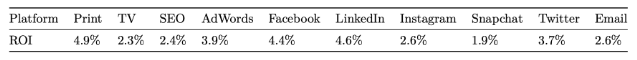

In [ ]:
# Storing the just the ROI of 2nd consulting firm in a list
medium2 = roi_data.columns.tolist()
budget2 = list(roi_data.loc['Second Firms ROI Estimate'].values)

medium_budget2_dict = dict(zip(medium2,budget2))

In [ ]:
#Running the Gurobi Function created for the Second recommended model
model2,ojModX2 = gurobi_optimize(medium_budget2_dict)

In [ ]:
# Returns based on 2nd consulting firms ROI data
model2.objVal  #Max Return from Ads

456000.0

In [ ]:
# The allocation of $10M amongst various Ad-Platforms
ojModX2.x

array([3000000.,       0.,       0., 1000000., 3000000., 3000000.,
             0.,       0.,       0.,       0.])

In [ ]:
# <!-- The Model gives out the following recommendations
output2 = list(ojModX2.x)
print('The Model 2 gives out the following recommendations, the values are in $(M)')
recommender_df['Model 2']= output2
recommender_df['Allocation 2']= budget2
recommender_df[['Medium','Allocation 2','Model 2']]

The Model 2 gives out the following recommendations, the values are in $(M)


,Medium,Allocation 2,Model 2
0,Print,0.049,3000000.0
1,TV,0.023,0.0
2,SEO,0.024,0.0
3,AdWords,0.039,1000000.0
4,Facebook,0.044,3000000.0
5,LinkedIn,0.046,3000000.0
6,Instagram,0.026,0.0
7,Snapchat,0.019,0.0
8,Twitter,0.037,0.0
9,Email,0.026,0.0


# Question 5
Are the allocations the same? Assuming the first ROI data is correct, if you were to use the second allocation (the allocation that assumed the second ROI data was correct) how much lower would the objective be relative to the optimal objective (the one that uses the first ROI data and the first allocation)? Assuming the second ROI data is correct, if you used the first allocation how much lower would the objective be relative to the optimal objective? Do you
think the third constraint above, based on your boss’ experience, is useful?

In [ ]:
# Analyzing the differences between both the allocations
recommender_df['Allocation Same or Changed'] = np.where(recommender_df['Model 2'] == recommender_df['Model 1'],'Same','Changed')
recommender_df

,Medium,Allocation 1,Model 1,Model 2,Allocation 2,Allocation Same or Changed
0,Print,0.031,0.0,3000000.0,0.049,Changed
1,TV,0.049,3000000.0,0.0,0.023,Changed
2,SEO,0.024,0.0,0.0,0.024,Same
3,AdWords,0.039,1000000.0,1000000.0,0.039,Same
4,Facebook,0.016,0.0,3000000.0,0.044,Changed
5,LinkedIn,0.024,0.0,3000000.0,0.046,Changed
6,Instagram,0.046,3000000.0,0.0,0.026,Changed
7,Snapchat,0.026,0.0,0.0,0.019,Same
8,Twitter,0.033,0.0,0.0,0.037,Same
9,Email,0.044,3000000.0,0.0,0.026,Changed


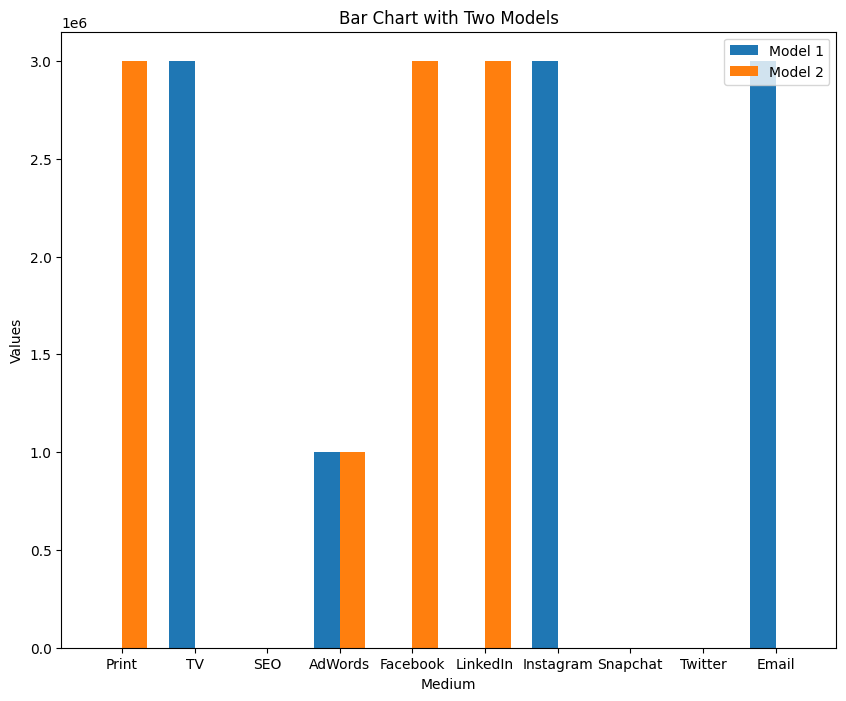

In [ ]:
x = np.arange(len(recommender_df.iloc[:, 0]))
bar_width = 0.35


plt.figure(figsize=(10, 8))
plt.bar(x - bar_width/2, recommender_df['Model 1'], width=bar_width, label='Model 1')
plt.bar(x + bar_width/2, recommender_df['Model 2'], width=bar_width, label='Model 2')
plt.xlabel('Medium')
plt.ylabel('Values')
plt.xticks(x, recommender_df.iloc[:, 0])

plt.legend()
plt.title('Bar Chart with Two Models')

plt.show()

### Assuming the first ROI data is correct, if you were to use the second allocation (the allocation that assumed the second ROI data was correct) how much lower would the objective be relative to the optimal objective (the one that uses the first ROI data and the first allocation

In [ ]:
val_1correct_with2 = model1.obj @ ojModX2.x
print('Assuming the first ROI with the Second Allocation, objective value obtained will be: $', val_1correct_with2)
print('This is $ {diff} less than the optimal objective value of $ {optimal}'.format(diff = model1.objVal - val_1correct_with2, optimal =  model1.objVal))


Assuming the first ROI with the Second Allocation, objective value obtained will be: $ 252000.0
This is $ 204000.0 less than the optimal objective value of $ 456000.0


### Assuming the second ROI data is correct, if you used the first allocation, how much lower would the objective be relative to the optimal objective?

In [ ]:
val_2correct_with1 = model2.obj @ ojModX1.x
print('Assuming the second ROI with the first Allocation, objective value obtained will be: $', val_2correct_with1)
print('This is $ {diff} less than the optimal objective value of $ {optimal}'.format(diff = model2.objVal - val_2correct_with1, optimal =  model2.objVal))


Assuming the second ROI with the first Allocation, objective value obtained will be: $ 264000.0
This is $ 192000.0 less than the optimal objective value of $ 456000.0


### Do you think the third constraint above, based on your boss’ experience, is useful?

In [ ]:
model1_woc3,ojModX1woc3 = gurobi_optimize(medium_budget_dict= medium_budget1_dict,marketing_budget =  10000000, n_constrs =2)


In [ ]:
model1_woc3.objval

465000.0

In [ ]:
ojModX1woc3.x

array([      0., 5000000.,       0.,       0.,       0.,       0.,
             0.,       0.,       0., 5000000.])

In [ ]:
recommender_df['Model 1 W/o Constraint 3']= ojModX1woc3.x
recommender_df[['Medium','Allocation 1','Model 1','Model 1 W/o Constraint 3']]

,Medium,Allocation 1,Model 1,Model 1 W/o Constraint 3
0,Print,0.031,0.0,0.0
1,TV,0.049,3000000.0,5000000.0
2,SEO,0.024,0.0,0.0
3,AdWords,0.039,1000000.0,0.0
4,Facebook,0.016,0.0,0.0
5,LinkedIn,0.024,0.0,0.0
6,Instagram,0.046,3000000.0,0.0
7,Snapchat,0.026,0.0,0.0
8,Twitter,0.033,0.0,0.0
9,Email,0.044,3000000.0,5000000.0


In [ ]:
model2_woc3,ojModX2woc3 = gurobi_optimize(medium_budget_dict= medium_budget2_dict,marketing_budget =  10000000, n_constrs =2)

In [ ]:
model2_woc3.objval

465000.0

In [ ]:
print('The optimal objective value changes by : $',model2_woc3.objval- model2.objval )

The optimal objective value changes by : $ 9000.0


In [ ]:
ojModX2woc3.x

array([5000000.,       0.,       0.,       0., 5000000.,       0.,
             0.,       0.,       0.,       0.])

In [ ]:
recommender_df['Model 2 W/o Constraint 3']= ojModX2woc3.x

recommender_df[['Medium','Allocation 2','Model 2','Model 2 W/o Constraint 3']]

,Medium,Allocation 2,Model 2,Model 2 W/o Constraint 3
0,Print,0.049,3000000.0,5000000.0
1,TV,0.023,0.0,0.0
2,SEO,0.024,0.0,0.0
3,AdWords,0.039,1000000.0,0.0
4,Facebook,0.044,3000000.0,5000000.0
5,LinkedIn,0.046,3000000.0,0.0
6,Instagram,0.026,0.0,0.0
7,Snapchat,0.019,0.0,0.0
8,Twitter,0.037,0.0,0.0
9,Email,0.026,0.0,0.0


**No, in both of the recommendations, the optimal objective value increases by $9,000 on removing the 3rd constraint, to $$ 465,000**

# Question 6
To explore this further perform some analysis of how your optimal allocation would change based on changes in the ROI data. Use the first ROI data as your starting point. By how much could each advertising medium’s ROI increase or decrease and still result in the same optimal allocation you found in step (3)?

In [ ]:

sentivity_analysis = pd.DataFrame(
    [
        pd.Series(ojModX1.SAObjLow, index=roi_data.columns),
        pd.Series(ojModX1.SAObjUp, index=roi_data.columns)
    ], index=["Lower Bound", "Upper Bound"]
).T

sentivity_analysis["Upper Bound Fix"] = np.where(sentivity_analysis["Upper Bound"]==np.inf,1,sentivity_analysis["Upper Bound"])
sentivity_analysis

,Lower Bound,Upper Bound,Upper Bound Fix
Print,-inf,0.049,0.049
TV,0.039,0.062,0.062
SEO,-inf,0.039,0.039
AdWords,0.033,0.046,0.046
Facebook,-inf,0.029,0.029
LinkedIn,-inf,0.039,0.039
Instagram,0.039,inf,1.000
Snapchat,-inf,0.039,0.039
Twitter,-inf,0.039,0.039
Email,0.029,inf,1.000


We can confirm this by investigating the allocations that result when all the ROIs reach their upper-bound values, ensuring the optimal allocation remains unchanged.

In [ ]:
sensitivity_dict = sentivity_analysis["Upper Bound Fix"].to_dict()


In [ ]:
model1_sa,ojModX1_sa = gurobi_optimize(sensitivity_dict)

In [ ]:
model1_sa.objval

6232000.0

# Question 7
Your boss has gained permission to reinvest half of the return. For example, if the marketing obtains a 4% return in January, the budget of February will be $10M + $10M × 4% × 50% = $10.2M. The monthly ROI for next year is given in an attached csv file. The three constraints given by your boss are still in place for each month. What is the optimal allocation for each
month?

In [ ]:
n_rows, n_columns = roi_mat.shape

In [ ]:
roi_mat.iloc[:, 1:] = roi_mat.iloc[:, 1:] * 0.01

In [ ]:
monthly_allocations_columns = roi_mat.columns.tolist() + ['MonthlyROI','Budget','Return percentage']
monthly_allocations = pd.DataFrame(columns=monthly_allocations_columns, index=range(n_rows))
monthly_allocations['Period'] = roi_mat['Period']

We want to be able to make the best decision for our business, i.e. maximise profit, and so we will need to understand whether re-investing will make more sense or keeping the base budget as $10 million wil make more sense. So we, will run our gurobi model to check the outcome from both of the available options.

## Compounding Budget

In [ ]:
monthly_budget = 10000000
for i in range(n_rows):
  monthly_medium_budget_dict = dict(zip(roi_mat.columns[1:].tolist(),roi_mat.iloc[i,1:].tolist()))
  monthly_model,ojModX_monthly = gurobi_optimize(medium_budget_dict= monthly_medium_budget_dict,marketing_budget =  monthly_budget)
  monthly_roi = monthly_model.objval
  # for medium,allocation in monthly_medium_budget_dict:
  allocations_list  = list(ojModX_monthly.x)
  for j in range(len(allocations_list)):
    monthly_allocations[medium_list[j]][i] = allocations_list[j].round(1) #monthly_medium_budget_dict[medium_list[j]] *
  monthly_allocations['MonthlyROI'][i] = round(monthly_roi,1)
  monthly_allocations['Budget'][i]= round(monthly_budget,1)

  monthly_return = monthly_roi/monthly_budget
  monthly_allocations['Return percentage'][i] =  round(monthly_return,4)
  reinvest = monthly_return/2
  monthly_budget = (1 + reinvest) * monthly_budget

In [ ]:
monthly_allocations

,Period,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email,MonthlyROI,Budget,Return percentage
0,January,3000000.0,0.0,0.0,1333333.3,0.0,0.0,2666666.7,0.0,0.0,3000000.0,373000.0,10000000,0.0373
1,February,3000000.0,0.0,0.0,2395500.0,3000000.0,0.0,0.0,0.0,1791000.0,0.0,406296.0,10186500.0,0.0399
2,March,0.0,0.0,0.0,3000000.0,0.0,3000000.0,1389648.0,0.0,3000000.0,0.0,414417.0,10389648.0,0.0399
3,April,0.0,0.0,0.0,3000000.0,0.0,3000000.0,3000000.0,0.0,1596856.5,0.0,414486.8,10596856.5,0.0391
4,May,1804099.9,0.0,0.0,0.0,0.0,0.0,3000000.0,0.0,3000000.0,3000000.0,432143.5,10804099.9,0.04
5,June,3000000.0,0.0,0.0,0.0,0.0,0.0,3000000.0,0.0,2020171.7,3000000.0,454766.5,11020171.7,0.0413
6,July,0.0,0.0,0.0,3000000.0,2247554.9,0.0,3000000.0,0.0,3000000.0,0.0,468654.6,11247554.9,0.0417
7,August,3000000.0,0.0,0.0,1827294.1,0.0,654588.2,0.0,0.0,3000000.0,3000000.0,487966.1,11481882.2,0.0425
8,September,1362932.6,0.0,0.0,3000000.0,0.0,3000000.0,0.0,0.0,3000000.0,1362932.6,459219.9,11725865.3,0.0392
9,October,0.0,0.0,0.0,3000000.0,0.0,3000000.0,3000000.0,0.0,0.0,2955475.3,427575.2,11955475.3,0.0358


In [ ]:
monthly_allocations['Return percentage'].mean()

0.04006666666666667

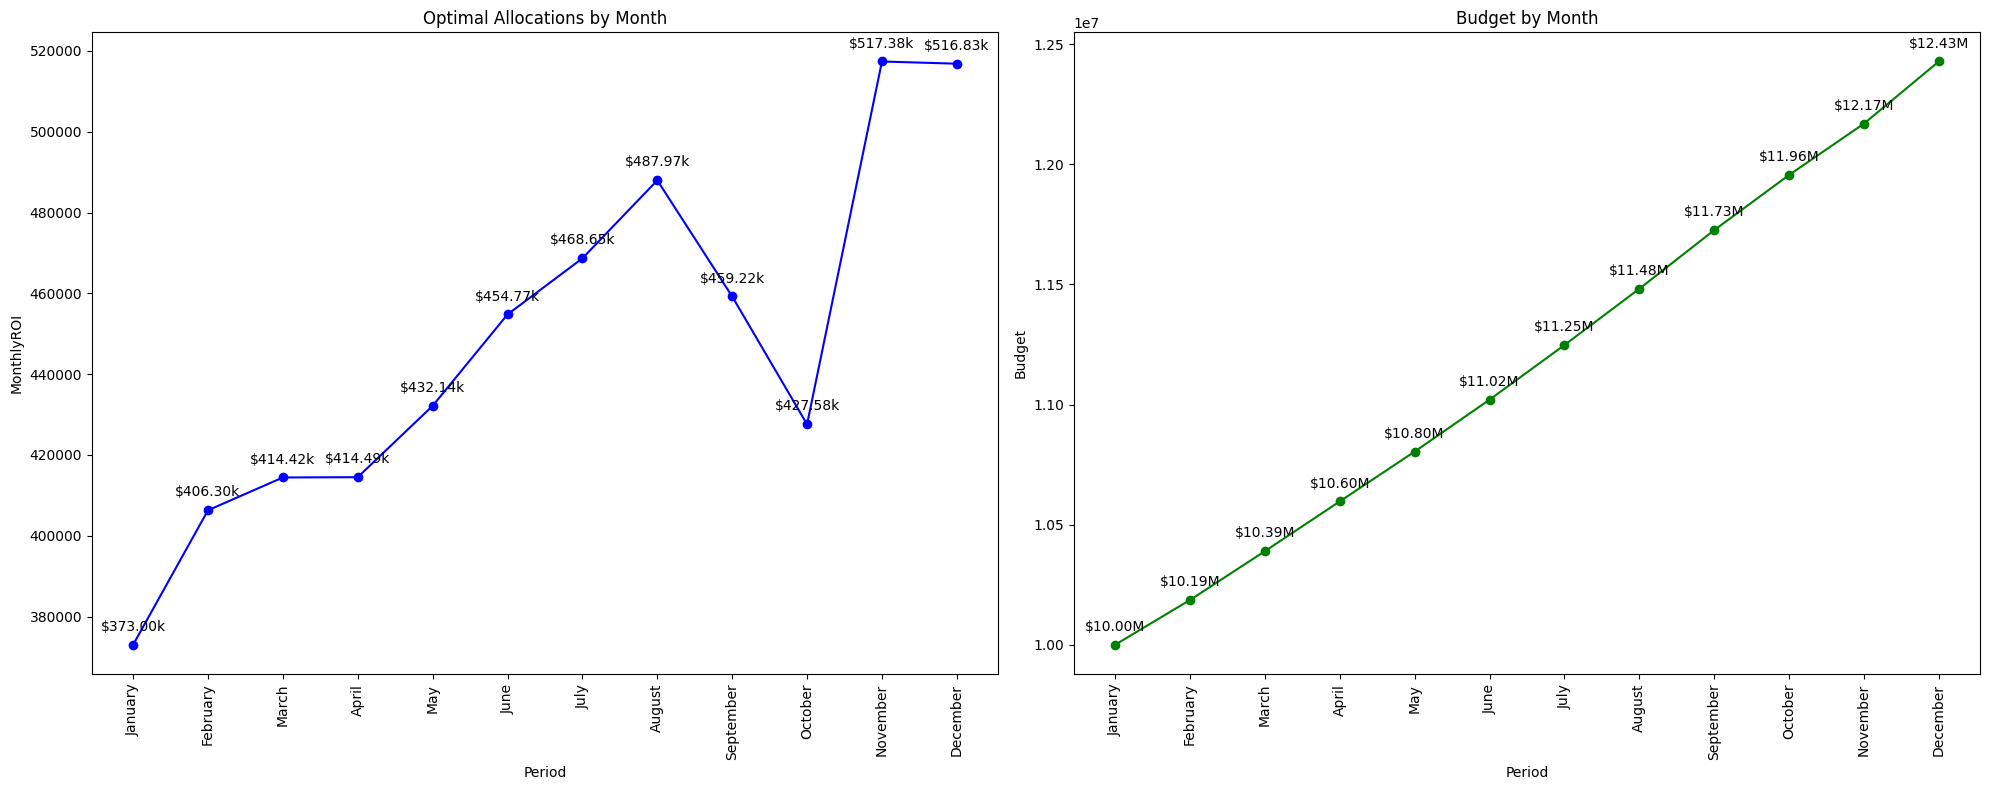

In [ ]:
# Create subplots with two side-by-side axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Line chart for MonthlyROI
ax1.plot(monthly_allocations['Period'], monthly_allocations['MonthlyROI'], marker='o', linestyle='-', color='b')
ax1.set_xlabel('Period')
ax1.set_ylabel('MonthlyROI')
ax1.set_title('Optimal Allocations by Month')
ax1.set_xticklabels(monthly_allocations['Period'], rotation=90)

for i, value in enumerate(monthly_allocations['MonthlyROI'].tolist()):
    ax1.annotate(f'${value/1000:.2f}k', (i, value), textcoords="offset points", xytext=(0,10), ha='center')

# Line chart for Budget
ax2.plot(monthly_allocations['Period'], monthly_allocations['Budget'], marker='o', linestyle='-', color='g')
ax2.set_xlabel('Period')
ax2.set_ylabel('Budget')
ax2.set_title('Budget by Month')
ax2.set_xticklabels(monthly_allocations['Period'], rotation=90)

for i, value in enumerate(monthly_allocations['Budget'].tolist()):
    ax2.annotate(f'${value/1e6:.2f}M', (i, value), textcoords="offset points", xytext=(0,10), ha='center')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## Keeping Base Budget Constant

In [ ]:
monthly_allocations1 = pd.DataFrame(columns=monthly_allocations_columns, index=range(n_rows))
monthly_allocations1['Period'] = roi_mat['Period']

monthly_budget = 10000000
for i in range(n_rows):
  monthly_medium_budget_dict = dict(zip(roi_mat.columns[1:].tolist(),roi_mat.iloc[i,1:].tolist()))
  monthly_model,ojModX_monthly = gurobi_optimize(medium_budget_dict= monthly_medium_budget_dict,marketing_budget =  monthly_budget)
  monthly_roi = monthly_model.objval
  # for medium,allocation in monthly_medium_budget_dict:
  allocations_list  = list(ojModX_monthly.x)
  for j in range(len(allocations_list)):
    monthly_allocations1[medium_list[j]][i] = allocations_list[j].round(1) #monthly_medium_budget_dict[medium_list[j]] *
  monthly_allocations1['MonthlyROI'][i] = round(monthly_roi,1)
  monthly_allocations1['Budget'][i]= round(monthly_budget,1)

  monthly_return = monthly_roi/monthly_budget
  monthly_allocations1['Return percentage'][i] = round(monthly_return,4)

  reinvest = monthly_return/2
  monthly_budget = (1 + reinvest) * 10000000

monthly_allocations1

,Period,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email,MonthlyROI,Budget,Return percentage
0,January,3000000.0,0.0,0.0,1333333.3,0.0,0.0,2666666.7,0.0,0.0,3000000.0,373000.0,10000000,0.0373
1,February,3000000.0,0.0,0.0,2395500.0,3000000.0,0.0,0.0,0.0,1791000.0,0.0,406296.0,10186500.0,0.0399
2,March,0.0,0.0,0.0,3000000.0,0.0,3000000.0,1199428.7,0.0,3000000.0,0.0,407378.9,10199428.7,0.0399
3,April,0.0,0.0,0.0,3000000.0,0.0,3000000.0,3000000.0,0.0,1199706.7,0.0,400189.4,10199706.7,0.0392
4,May,1196176.9,0.0,0.0,0.0,0.0,0.0,3000000.0,0.0,3000000.0,3000000.0,410866.2,10196176.9,0.0403
5,June,3000000.0,0.0,0.0,0.0,0.0,0.0,3000000.0,0.0,1201480.5,3000000.0,423656.3,10201480.5,0.0415
6,July,0.0,0.0,0.0,3000000.0,1207644.5,0.0,3000000.0,0.0,3000000.0,0.0,428098.1,10207644.5,0.0419
7,August,2709694.9,0.0,0.0,1500000.0,0.0,0.0,0.0,0.0,3000000.0,3000000.0,437807.2,10209694.9,0.0429
8,September,607203.8,0.0,0.0,3000000.0,0.0,3000000.0,0.0,0.0,3000000.0,607203.8,402540.3,10214407.6,0.0394
9,October,0.0,0.0,0.0,3000000.0,0.0,3000000.0,3000000.0,0.0,0.0,1197045.3,371305.5,10197045.3,0.0364


In [ ]:
monthly_allocations1['Return percentage'].mean()

0.04036666666666667

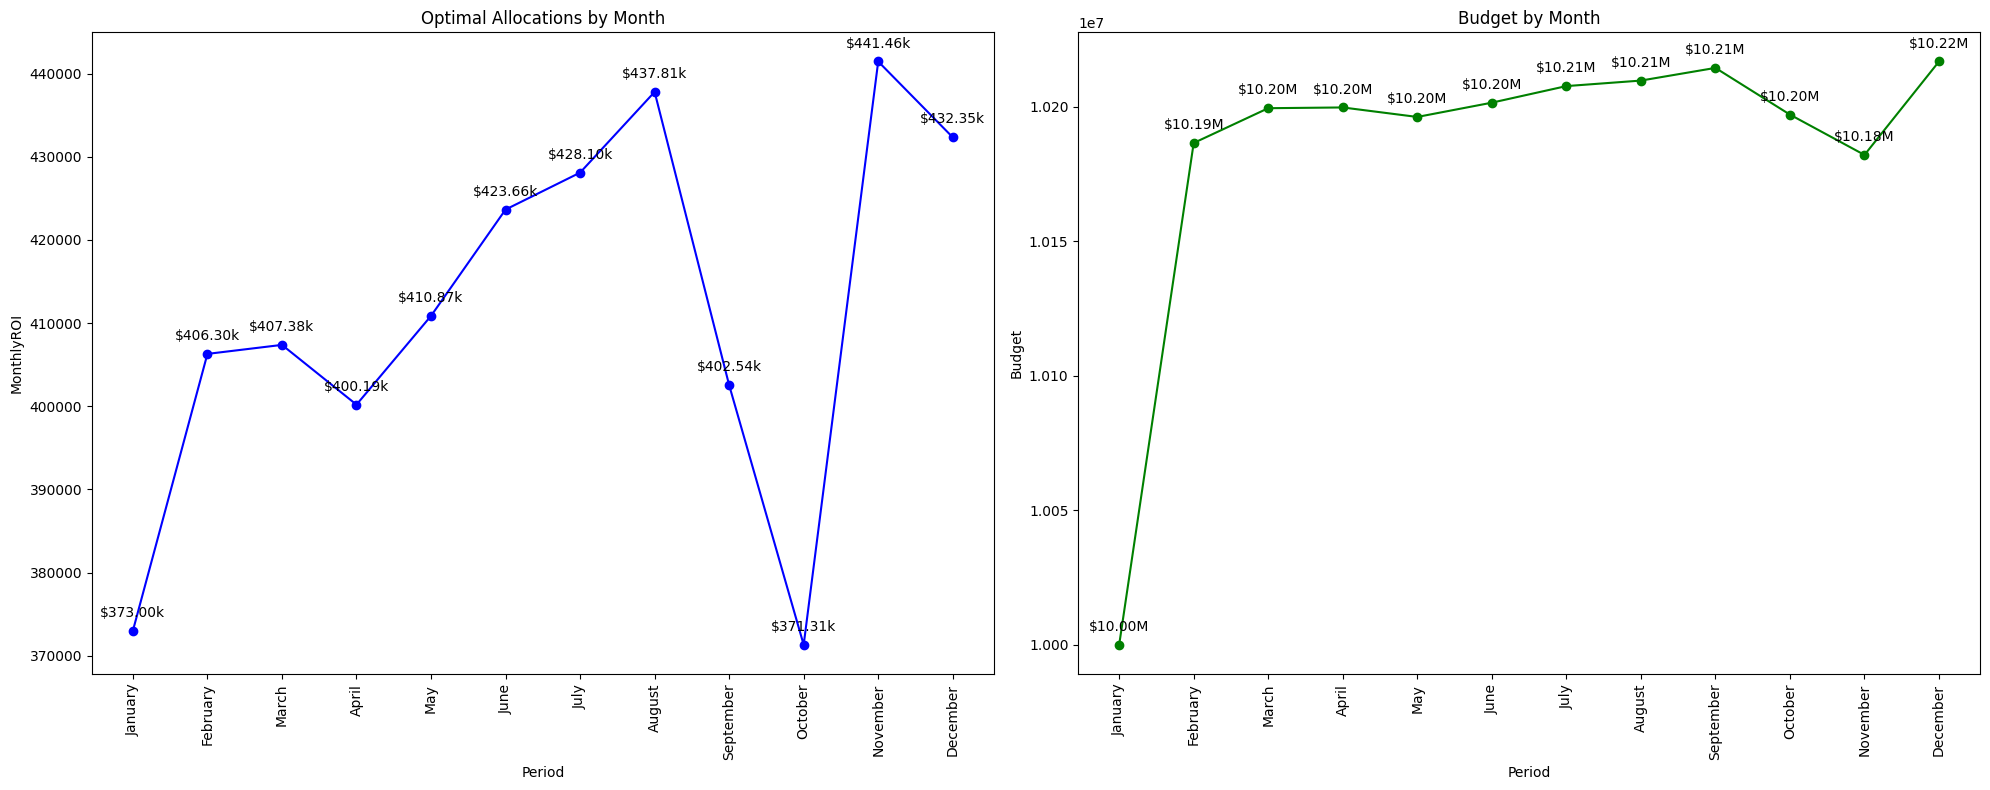

In [ ]:
# Create subplots with two side-by-side axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Line chart for MonthlyROI
ax1.plot(monthly_allocations1['Period'], monthly_allocations1['MonthlyROI'], marker='o', linestyle='-', color='b')
ax1.set_xlabel('Period')
ax1.set_ylabel('MonthlyROI')
ax1.set_title('Optimal Allocations by Month')
ax1.set_xticklabels(monthly_allocations1['Period'], rotation=90)

for i, value in enumerate(monthly_allocations1['MonthlyROI'].tolist()):
    ax1.annotate(f'${value/1000:.2f}k', (i, value), textcoords="offset points", xytext=(0,10), ha='center')

# Line chart for Budget
ax2.plot(monthly_allocations1['Period'], monthly_allocations1['Budget'], marker='o', linestyle='-', color='g')
ax2.set_xlabel('Period')
ax2.set_ylabel('Budget')
ax2.set_title('Budget by Month')
ax2.set_xticklabels(monthly_allocations1['Period'], rotation=90)

for i, value in enumerate(monthly_allocations1['Budget'].tolist()):
    ax2.annotate(f'${value/1e6:.2f}M', (i, value), textcoords="offset points", xytext=(0,10), ha='center')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## Results
The returns from both the Budget methods are coming out to be approximately equal. In this case, we can go for both the strategies depending on the various other factors, which are discussed in length in our business report.

# Question 8
A stable budget is defined as a monthly allocation such that for each platform the monthly change in spend is no more than $1M. Is the allocation you found stable? If it isn’t, you do not
need to solve a new optimization model. Describe how my might model this?

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_differences = pd.DataFrame(columns=monthly_allocations_columns, index=range(n_rows))
df_differences['Period'] = roi_mat['Period']

for i in range(n_rows-1):
  df_differences.iloc[i+1,1:] =   monthly_allocations.iloc[i+1,1:] -   monthly_allocations.iloc[i,1:]

df_differences.iloc[:, :-2]

,Period,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email,MonthlyROI
0,January,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,February,0.0,0.0,0.0,1062166.7,3000000.0,0.0,-2666666.7,0.0,1791000.0,-3000000.0,33296.0
2,March,-3000000.0,0.0,0.0,604500.0,-3000000.0,3000000.0,1389648.0,0.0,1209000.0,0.0,8121.0
3,April,0.0,0.0,0.0,0.0,0.0,0.0,1610352.0,0.0,-1403143.5,0.0,69.8
4,May,1804099.9,0.0,0.0,-3000000.0,0.0,-3000000.0,0.0,0.0,1403143.5,3000000.0,17656.7
5,June,1195900.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-979828.3,0.0,22623.0
6,July,-3000000.0,0.0,0.0,3000000.0,2247554.9,0.0,0.0,0.0,979828.3,-3000000.0,13888.1
7,August,3000000.0,0.0,0.0,-1172705.9,-2247554.9,654588.2,-3000000.0,0.0,0.0,3000000.0,19311.5
8,September,-1637067.4,0.0,0.0,1172705.9,0.0,2345411.8,0.0,0.0,0.0,-1637067.4,-28746.2
9,October,-1362932.6,0.0,0.0,0.0,0.0,0.0,3000000.0,0.0,-3000000.0,1592542.7,-31644.7


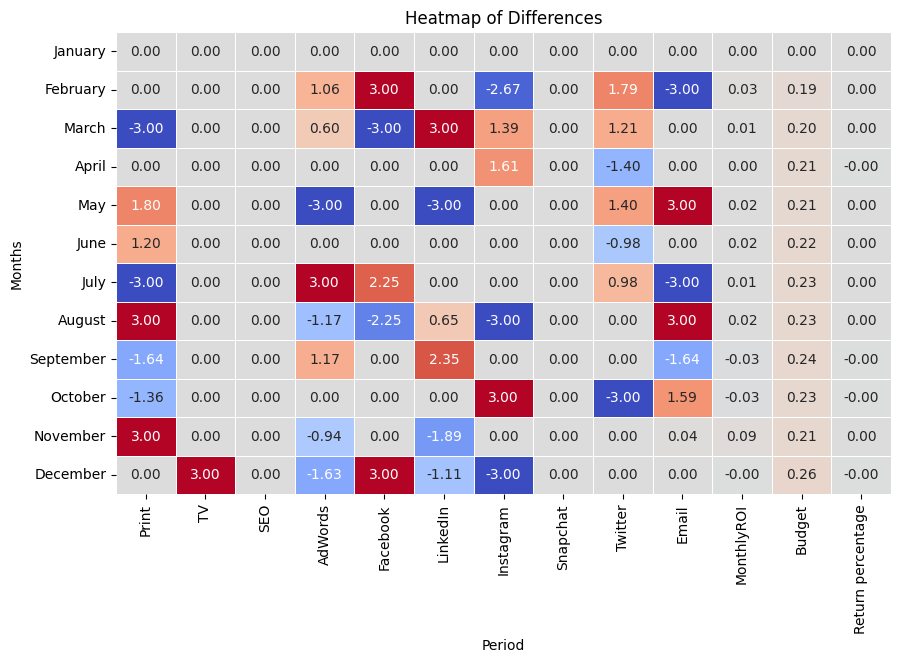

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a copy of the DataFrame with 'Period' as the index
df_differences_indexed = df_differences.copy()
df_differences_indexed.set_index('Period', inplace=True)

# Fill NaN values with 0
df_differences_indexed.fillna(0, inplace=True)

# Create a heatmap without formatting (numeric values)
plt.figure(figsize=(10, 6))
sns.heatmap(df_differences_indexed/1000000, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar=False)

# Add labels and title
plt.xlabel('Period')
plt.ylabel('Months')
plt.title('Heatmap of Differences')

# Show the plot
plt.show()


In [ ]:
df_differences_indexed['Budget Stablility'] = True

# Check each row for values outside the range (-1, 1) and flag as 'Unstable' if found
for index, row in df_differences_indexed.iterrows():
    if any(value < -1 or value > 1 for value in row):
        df_differences_indexed.at[index, 'Budget Stablility'] = False

df_differences_indexed['Budget Stablility'] = np.where(df_differences_indexed['Budget Stablility'] == False, 'Unstable','Stable')

df_differences_indexed['Budget Stablility'][0] = '-'

df_differences_indexed['Budget Stablility'].reset_index()

,Period,Budget Stablility
0,January,-
1,February,Unstable
2,March,Unstable
3,April,Unstable
4,May,Unstable
5,June,Unstable
6,July,Unstable
7,August,Unstable
8,September,Unstable
9,October,Unstable


Since in this system above, ALL the above months have atleast 1 allocation that has a difference of $1M, so we can say that it is Unstable Budget.

To ensure that we can maintain a stable budget, we can add additional constraints to the model that ensures that the absolute difference between the budget for each platform is no more than $1 million.

To achieve this, we could have one variable defined for each of the decision variables, which tracks the current value of the respective decision variable. When entering the next loop, we can include the following constraint:

$x_{i-1} \leq x_i \leq x_{i+1}$.
